In [81]:
using LogDensityProblems: LogDensityProblems;
using Distributions
using DelimitedFiles
using Random: Random
using DynamicPPL
using Turing
using LinearAlgebra
using AbstractMCMC

using AdvancedMH
import AdvancedMH; AMH = AdvancedMH
data = readdlm("data.txt")
t, y, yerr = data[:, 1], data[:, 2], data[:, 3]

using LinearAlgebra
using Turing
using Turing.Inference: _params_to_array
using DynamicPPL: Metadata, VarInfo, TypedVarInfo,
    islinked, invlink!, link!,
    setindex!!, push!!,
    setlogp!!, getlogp,
    VarName, getsym, vectorize,
    _getvns, getdist

fun(x,α,β,γ) = @. α * x^2 + β * x + γ
x = 0.0:0.5:15.0

@model function InferenceModel(y, t)
	α ~ Normal(2, 1)
	β ~ Normal(0, 1)
	γ ~ Normal(-2, 1)
	return y ~ MvNormal(fun(t, α, β, γ), I)
end

mymod = InferenceModel(y, t)


Model{typeof(InferenceModel), (:y, :t), (), (), Tuple{Vector{Float64}, Vector{Float64}}, Tuple{}, DefaultContext}(InferenceModel, (y = [-7.847359573362729, -1.3315947853190484, -0.5803510819209906, 1.1102764392598465, 9.988712842023517, 19.064552472027945, 22.360242601879634, 33.29037569667121, 44.30268624603188, 61.37029298584822  …  329.46633376403497, 367.3951090879816, 401.4586394961345, 429.0802630665355, 468.61496107560146, 507.32002150234865, 545.8993822489858, 589.8509862829196, 640.5342047989809, 675.5419963803967], t = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]), NamedTuple(), DefaultContext())

In [82]:
function tune_lengthscale(t, μ, N_e, N_c, M_adapt)
	N_e = max(1, N_e)

	if t <= M_adapt
		return 2μ * N_e / (N_e + N_c)
	else
		return μ
	end
end

function get_complementary(i, N)
	indices = collect(1:N)
	deleteat!(indices, i)
	return indices
end

function get_direction_vector(S, l, m, μ)
	return μ * (S[l].x - S[m].x)
end

""" 
	DifferentialMove(rng, k, μ, S, N)

	Perform a differential move for walker k.

	# Arguments
	- `rng::AbstractRNG`: Random number generator.
	- `k::Int`: Index of the walker.
	- `μ::Float64`: Lengthscale.
	- `S::Array{Float64, 2}`: Array of walker positions.
	- `N::Int`: Number of walkers.

	# Returns
	- `ηₖ::Array{Float64, 1}`: Differential move.
"""
function DifferentialMove(rng, k, μ, S, N)
	# work on walker k
	indices = get_complementary(k, N)
	# draw two random indices from the complementary set, without replacement
	l, m = sample(rng, indices, 2, replace = false)
	return get_direction_vector(S, l, m, μ)
end

DifferentialMove

In [83]:
struct EnsembleSliceSampler{T<:Float64,A<:Int64} <: AdvancedMH.MHSampler
    "initial length scale"
    μ_init::T
    "number of adapation steps"
    M_adapt::A
    "number of walkers"
    n_walkers::A
    "max number of attempts"
    max_steps::A
end

In [138]:
struct EnSS{space, E <: EnsembleSliceSampler} <: Turing.Inference.InferenceAlgorithm
	ensemble::E
end

function EnSS(n_walkers::Int, μ_init = 1.0, M_adapt = 20, max_steps = 10000)
	ensemble = EnsembleSliceSampler(μ_init, M_adapt, n_walkers, max_steps)
	return EnSS{(), typeof(ensemble)}(ensemble)
end

struct EnSSState{V <: AbstractVarInfo, S}
	vi::V
	states::S
end

function AbstractMCMC.step(
	rng::Random.AbstractRNG,
	model::Model,
	spl::Sampler{<:EnSS};
	resume_from = nothing,
	initial_params = nothing,
	kwargs...)
	if resume_from !== nothing
		state = loadstate(resume_from)
		return AbstractMCMC.step(rng, model, spl, state; kwargs...)
	end

	# Sample from the prior
	n = spl.alg.ensemble.n_walkers
	vis = [VarInfo(rng, model, SampleFromPrior()) for _ in 1:n]

	# Update the parameters if provided.
	if initial_params !== nothing
		length(initial_params) == n ||
			throw(ArgumentError("initial parameters have to be specified for each walker"))
		vis = map(vis, initial_params) do vi, init
			vi = DynamicPPL.initialize_parameters!!(vi, init, spl, model)

			# Update log joint probability.
			last(DynamicPPL.evaluate!!(model, rng, vi, SampleFromPrior()))
		end
	end

	# Compute initial transition and states.
	transition = map(Base.Fix1(Turing.Inference.Transition, model), vis)
	# transition = [Transition(model, vi, false, spl.alg.ensemble.μ_init, 1) for vi in vis]
	# TODO: Make compatible with immutable `AbstractVarInfo`.
	state = EnSSState(
		vis[1],
		map(vis) do vi
			vi = DynamicPPL.link!!(vi, spl, model)
			Transition(vi[spl], getlogp(vi), false, spl.alg.ensemble.μ_init, 1)
		end,
	)

	return transition, state
end

function AbstractMCMC.step(
	rng::Random.AbstractRNG, model::Model, spl::Sampler{<:EnSS}, state::EnSSState; kwargs...)
	# Generate a log joint function.
	vi = state.vi
	densitymodel = AMH.DensityModel(
		Base.Fix1(LogDensityProblems.logdensity, Turing.LogDensityFunction(model, vi)),
	)

	# Compute the next states.
	states = last(AbstractMCMC.step(rng, densitymodel, spl.alg.ensemble, state.states))

	# Compute the next transition and state.
	transition = map(states) do _state
		vi = setindex!!(vi, _state.params, spl)
		t = Turing.Inference.Transition(getparams(model, vi), _state.lp)#, false, spl.alg.ensemble.μ_init, 1)
		return t
	end
	newstate = EnSSState(vi, states)

	return transition, newstate
end

function AbstractMCMC.bundle_samples(
	samples::Vector{<:Vector},
	model::AbstractMCMC.AbstractModel,
	spl::Sampler{<:EnSS},
	state::EnSSState,
	chain_type::Type{MCMCChains.Chains};
	save_state = false,
	sort_chain = false,
	discard_initial = 0,
	thinning = 1,
	kwargs...)
	# Convert transitions to array format.
	# Also retrieve the variable names.
	params_vec = map(Base.Fix1(_params_to_array, model), samples)

	# Extract names and values separately.
	varnames = params_vec[1][1]
	varnames_symbol = map(Symbol, varnames)
	vals_vec = [p[2] for p in params_vec]

	# Get the values of the extra parameters in each transition.
	extra_vec = map(Turing.Inference.get_transition_extras, samples)

	# Get the extra parameter names & values.
	extra_params = extra_vec[1][1]
	extra_values_vec = [e[2] for e in extra_vec]

	# Extract names & construct param array.
	nms = [varnames_symbol; extra_params]
	# `hcat` first to ensure we get the right `eltype`.
	x = hcat(first(vals_vec), first(extra_values_vec))
	# Pre-allocate to minimize memory usage.
	parray = Array{eltype(x), 3}(undef, length(vals_vec), size(x, 2), size(x, 1))
	for (i, (vals, extras)) in enumerate(zip(vals_vec, extra_values_vec))
		parray[i, :, :] = transpose(hcat(vals, extras))
	end

	# Get the average or final log evidence, if it exists.
	le = Turing.Inference.getlogevidence(samples, state, spl)

	# Set up the info tuple.
	info = (varname_to_symbol = OrderedDict(zip(varnames, varnames_symbol)),)
	if save_state
		info = merge(info, (model = model, sampler = spl, samplerstate = state))
	end

	# Concretize the array before giving it to MCMCChains.
	parray = MCMCChains.concretize(parray)

	# Chain construction.
	chain = MCMCChains.Chains(
		parray,
		nms,
		(internals = extra_params,);
		evidence = le,
		info = info,
		start = discard_initial + 1,
		thin = thinning,
	)

	return sort_chain ? sort(chain) : chain
end

struct Transition{T, L <: Real} <: AdvancedMH.AbstractTransition
	params::T
	lp::L
	accepted::Bool
	μ::L
	t::Int
end


# Calculate the density of the model given some parameterization.
logdensity(model::DensityModel, params) = model.logdensity(params)
logdensity(::DensityModel, t::Transition) = t.lp
logdensity(model::AbstractMCMC.LogDensityModel, params) = LogDensityProblems.logdensity(model.logdensity, params)
logdensity(::AbstractMCMC.LogDensityModel, t::Transition) = t.lp

# Store the new draw, its log density, and draw information
Transition(model::AdvancedMH.DensityModelOrLogDensityModel, params, accepted, μ, t) = Transition(params, logdensity(model, params), accepted, μ, t)
function Transition(model::AbstractMCMC.LogDensityModel, params, accepted, μ, t)
	return Transition(params, LogDensityProblems.logdensity(model.logdensity, params), accepted, μ, t)
end
function Transition(model::DynamicPPL.Model, vie::AbstractVarInfo, accepted::Bool, μ, t)
	θ = getparams(model, vie)
	lp = getlogp(vie)
	return Transition(θ, lp, accepted, μ, t)
end

# Transition(mymod,vie, false, 1.0, 1)


Transition

In [139]:
rng = Random.MersenneTwister(0)
import Turing.Inference: getparams
vie = DynamicPPL.VarInfo(rng, mymod, DynamicPPL.SampleFromPrior()) 
params = getparams(mymod, vie)

θ = getparams(mymod, vie)
lp = getlogp(vie)

-12592.83027493578

In [140]:
Transition(mymod,vie, false, 1.0, 1)


Transition{Vector{Tuple{VarName{sym, typeof(identity)} where sym, Float64}}, Float64}(Tuple{VarName{sym, typeof(identity)} where sym, Float64}[(α, 2.6791074260357775), (β, 0.8284134829000359), (γ, -2.353007400300596)], -12592.83027493578, false, 1.0, 1)

In [141]:
struct ZeusProposal{P, F<:AbstractFloat} <: AdvancedMH.Proposal{P}
    proposal :: P
    μ::F
end

In [142]:
function AbstractMCMC.bundle_samples(
    ts::Vector{<:AMH.AbstractTransition},
    model::AMH.DensityModelOrLogDensityModel,
    sampler::AMH.MHSampler,
    state,
    chain_type::Type{Vector{NamedTuple}};
    param_names=missing,
    kwargs...)
    # Check if we received any parameter names.
    if ismissing(param_names)
        param_names = ["param_$i" for i in 1:length(keys(ts[1].params))]
    else
        # Deepcopy to be thread safe.
        param_names = deepcopy(param_names)
    end

    push!(param_names, "lp")

    # Turn all the transitions into a vector-of-NamedTuple.
    ks = tuple(Symbol.(param_names)...)
    nts = [NamedTuple{ks}(tuple(t.params..., t.lp)) for t in ts]

    return nts
end

function AbstractMCMC.bundle_samples(
    ts::Vector{<:Transition{<:NamedTuple}},
    model::AMH.DensityModelOrLogDensityModel,
    sampler::AMH.MHSampler,
    state,
    chain_type::Type{Vector{NamedTuple}};
    param_names=missing,
    kwargs...)
    # If the element type of ts is NamedTuples, just use the names in the
    # struct.

    # Extract NamedTuples
    nts = map(x -> merge(x.params, (lp=x.lp,)), ts)

    # Return em'
    return nts
end


In [190]:
function AbstractMCMC.step(
	rng::Random.AbstractRNG,
	model::AdvancedMH.DensityModelOrLogDensityModel,
	spl::EnsembleSliceSampler,
	params_prev::Vector{<:Transition};
	kwargs...)
	transitions = propose(rng, spl, model, params_prev)
	return transitions, transitions
end

function propose(
	rng::Random.AbstractRNG,
	spl::EnsembleSliceSampler,
	model::AdvancedMH.DensityModelOrLogDensityModel,
	walkers::Vector{<:Transition})
	new_walkers = similar(walkers)
	n_walkers = spl.n_walkers
	M_adapt = spl.M_adapt
	μ = walkers[1].μ

	R, L, N_e, N_c = 0.0, 0.0, 0, 0
	for i in 1:n_walkers
		walker = walkers[i]

		indices = get_complementary(i, n_walkers)
		l, m = sample(rng, indices, 2, replace = false)

		new_walkers[i], R, L, N_e, N_c = move(rng, spl, model, walker, walkers[l], walkers[m], R, L, N_e, N_c)
	end

	t = new_walkers[1].t
	N_e = max(1, N_e)

	if t <= M_adapt
		new_μ = 2μ * N_e / (N_e + N_c)
		new_walkers_2 = similar(new_walkers)
		for i in 1:n_walkers
			new_walkers_2[i] = Transition(model, new_walkers[i].params, true, new_μ, t)
		end
		# println(new_μ)

		return new_walkers_2
	else
		# println("stop here")
		return new_walkers
	end
end

function DifferentialMove(μ, walker_l, walker_m)
	return μ * (walker_l - walker_m)
end

function move(
	rng::Random.AbstractRNG,
	spl::EnsembleSliceSampler,
	model::AdvancedMH.DensityModelOrLogDensityModel,
	walker::Transition,
	walker_l::Transition,
	walker_m::Transition, R::Float64, L::Float64, N_e::Int, N_c::Int)
	max_steps = spl.max_steps
	μ = walker.μ

	X′ = 0.0
	# get the move to the new position
	ηₖ = DifferentialMove(μ, walker_l.params, walker_m.params)
	# draw y position 
	δ = rand(rng, Exponential(1))
	Y = walker.lp - δ


	L = -rand(rng)
	R = L + 1
	l = 0
	# println("attention!")
	Y′ = Transition(model, walker.params + L .* ηₖ, false, μ, walker.t).lp

	while Y < Y′
		L = L - 1
		N_e = N_e + 1
		l += 1
		if l == max_steps
			error("Max steps reached", " iteration: ", t, " walker: ", k)
		end
		Y′ = Transition(model, walker.params + L .* ηₖ, false, μ, walker.t).lp
	end
	l = 0
	Y′ = Transition(model, walker.params + R .* ηₖ, false, μ, walker.t).lp
	while Y < Y′
		R = R + 1
		N_e = N_e + 1
		l += 1
		if l == max_steps
			error("Max steps reached")
		end
		Y′ = Transition(model, walker.params + R .* ηₖ, false, μ, walker.t).lp
	end

	l = 0
	while true
		l += 1
		X′ = rand(rng, Uniform(L, R))
		Y′ = Transition(model, walker.params + X′ .* ηₖ, false, μ, walker.t).lp
		if Y < Y′
			break
		end
		if X′ < 0
			L = X′
			N_c = N_c + 1
		else
			R = X′
			N_c = N_c + 1
		end
		if l == max_steps
			error("Max steps reached")
		end
	end

	Xₖ = X′ .* ηₖ + walker.params

	return Transition(model, Xₖ, true, μ, walker.t + 1), R, L, N_e, N_c

end

DynamicPPL.getspace(::EnSS) = ()

In [200]:
spl = EnSS(25)

EnSS{(), EnsembleSliceSampler{Float64, Int64}}(EnsembleSliceSampler{Float64, Int64}(1.0, 20, 25, 10000))

In [201]:
rng = Random.MersenneTwister(0)
chain = sample(rng,mymod, spl, 2000,progress=false);

In [202]:
chain[100:end,:,:]

Chains MCMC chain (1901×4×25 Array{Float64, 3}):

Iterations        = 100:1:2000
Number of chains  = 25
Samples per chain = 1901
parameters        = α, β, γ
internals         = lp

Summary Statistics
  parameters      mean       std      mcse    ess_bulk     ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64     Float64      Float64   Float64  ⋯

           α    3.0480    0.0093    0.0001   9254.5823   12925.3829    1.0024  ⋯
           β   -0.2443    0.1415    0.0015   9251.6233   13053.0569    1.0021  ⋯
           γ   -3.4585    0.4430    0.0046   9297.9930   13613.8061    1.0017  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           α    3.0297    3.0416    3.0479    3.0543    3.0663
           β   -0.5215   -0.3399   -0.2432   -0.1485    0.0324
           γ   -4.3289   -3.7569   -3.4577   -3

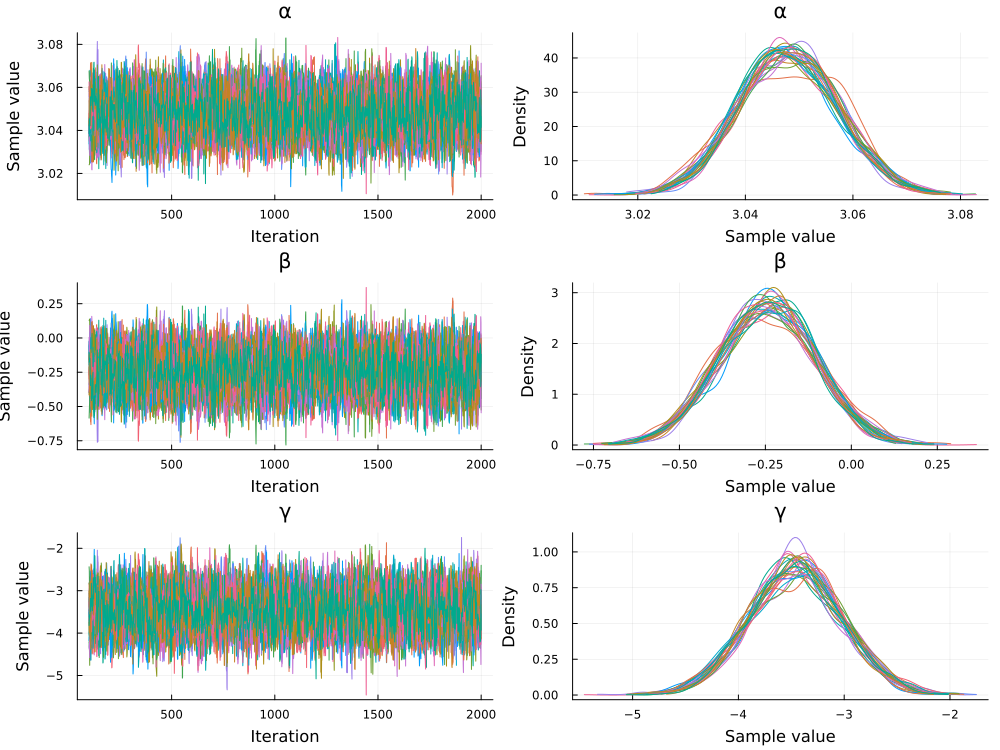

In [203]:
using StatsPlots
StatsPlots.plot(chain[100:end,:,:])

In [189]:
Array(chain,append_chains=false)

5-element Vector{Matrix{Float64}}:
 [2.6791074260357775 0.8284134829000359 -2.353007400300596; 2.432332719782235 0.7671938236919813 -2.358687026928761]
 [1.8651461280694783 0.5866170746331097 -1.7026641491505838; 2.8527434367487814 1.0934450523693562 -2.3074318991694898]
 [2.0649475485483424 -0.10901738508171745 -2.514210390833322; 2.1671687491309273 0.676336309651388 -1.9439758353360408]
 [3.574330202136989 -0.6889071278256981 -2.7628038164104582; 0.7524125620873241 4.460742749632663 2.8169971290462628]
 [2.3974824092181635 0.8116296225068749 -2.3463546042787984; 2.9698432379828787 -0.4566692726323862 -2.6632455733244425]

In [75]:
using Turing
# Let's define some type that represents the model.
struct RegressionProblem{Ty <: AbstractVector}
	"mean of the isotropic Gaussian"
	y::Ty
	x::Ty
	# α::A
	# β::A
	# γ::A
end
LogDensityProblems.dimension(model::RegressionProblem) = 3

function LogDensityProblems.logdensity(model::RegressionProblem, θ::AbstractVector{<:Real})
	α, β, γ = θ
	lp = logpdf(Normal(2, 1), α)
	lp += logpdf(Normal(0, 1), β)
	lp += logpdf(Normal(-2, 1), γ)
	ll = logpdf(MvNormal(fun(model.x, α, β, γ), 1), model.y)
	return ll + lp
end


fun(x,α,β,γ) = @. α * x^2 + β * x + γ
x = 0.0:0.5:15.0

LogDensityProblems.capabilities(model::RegressionProblem) = LogDensityProblems.LogDensityOrder{0}()
MYmodel = RegressionProblem(y,t)

RegressionProblem{Vector{Float64}}([-7.847359573362729, -1.3315947853190484, -0.5803510819209906, 1.1102764392598465, 9.988712842023517, 19.064552472027945, 22.360242601879634, 33.29037569667121, 44.30268624603188, 61.37029298584822  …  329.46633376403497, 367.3951090879816, 401.4586394961345, 429.0802630665355, 468.61496107560146, 507.32002150234865, 545.8993822489858, 589.8509862829196, 640.5342047989809, 675.5419963803967], [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0])

In [80]:
rng = Random.default_rng(89)
ndims = 3
nwalkers = 2 * ndims
sampler = EnsembleSliceSampler(1.0, 100, 6, 10_000)
init_p = [ Walker(randn(rng,ndims)) for i in 1:nwalkers]
state = ESState(init_p, 1.0, 1)

ESState{Vector{Walker{Vector{Float64}}}, Float64, Int64}(Walker{Vector{Float64}}[Walker{Vector{Float64}}([-1.4700350877845583, -0.28079717563588386, 0.21819935075366134]), Walker{Vector{Float64}}([0.0015359654656915698, -1.292041156524825, -0.5001426097687957]), Walker{Vector{Float64}}([1.6207908277595857, 0.6888362954156618, -1.3282856773114313]), Walker{Vector{Float64}}([0.5969900613470707, 1.5204721141867714, -1.1102535821792976]), Walker{Vector{Float64}}([0.555143907575193, -2.7896723633694007, 0.9822429048406388]), Walker{Vector{Float64}}([1.2773868591229607, 1.6377902315278676, 0.09285335904755491])], 1.0, 1)

In [81]:
rng = Random.default_rng(132)

x_next, state_next = AbstractMCMC.step(
    rng,
    AbstractMCMC.LogDensityModel(MYmodel),
    sampler,
    state
)

(ESSample{Vector{Any}}(Any[Walker{Vector{Float64}}([-1.320428073770339, 0.6363172898812206, 0.033969218834172865]), Walker{Vector{Float64}}([3.7951771327792407, -0.10192513139156234, -2.398279039127977]), Walker{Vector{Float64}}([2.4451932864233825, 1.407245953793178, -1.8581195134353679]), Walker{Vector{Float64}}([1.982880798480703, 3.2158690377767565, -1.8190461466202503]), Walker{Vector{Float64}}([2.2543304577792065, -1.3089489421531624, -0.10980445470264522]), Walker{Vector{Float64}}([2.427923317230537, 7.072128628470728, -1.0860031172199034])]), ESState{Vector{Any}, Float64, Int64}(Any[Walker{Vector{Float64}}([-1.320428073770339, 0.6363172898812206, 0.033969218834172865]), Walker{Vector{Float64}}([3.7951771327792407, -0.10192513139156234, -2.398279039127977]), Walker{Vector{Float64}}([2.4451932864233825, 1.407245953793178, -1.8581195134353679]), Walker{Vector{Float64}}([1.982880798480703, 3.2158690377767565, -1.8190461466202503]), Walker{Vector{Float64}}([2.2543304577792065, -1.30

In [66]:
using DynamicPPL

In [83]:
function AbstractMCMC.step(
    rng::Random.AbstractRNG,
    model_wrapper::AbstractMCMC.LogDensityModel,
    ::EnsembleSliceSampler;
    kwargs...)
    model = model_wrapper.logdensity
    nwalkers = sampler.N_walkers
    ndims = LogDensityProblems.dimension(model)
    # x = randn(rng,nwalkers,ndims)
    init_p = [ Walker(randn(rng,ndims)) for i in 1:nwalkers]
    # x = [DynamicPPL.VarInfo(rng, model, DynamicPPL.SampleFromPrior()) for _ in 1:nwalkers]
    # x = mapreduce(permutedims, hcat, x)
    return ESSample(init_p),  ESState(init_p, 1.0, 1)
end

In [87]:

# samples = sample(MYmodel, sampler, 1_000; initial_state=state, progress=false)
# using MCMCChains
# samples_matrix = stack(sample -> sample.x, samples)
# samples_matrix = stack(sample -> sample.x, samples_matrix)
# samples_matrix = permutedims(samples_matrix, [3, 1, 2])

# ch = Chains(samples_matrix,[:α,:β,:γ])
# using StatsPlots
# plot(ch[100:end,:,:])

In [90]:
using LinearAlgebra

@model function InferenceModel(y, t)
	α ~ Normal(2, 1)
	β ~ Normal(0, 1)
	γ ~ Normal(-2, 1)
	return y ~ MvNormal(fun(t, α, β, γ), I)
end

mymod = InferenceModel(y, t)
# Turing.Inference.getparams(::Turing.Model, sample::ESSample) = sample.x
function Turing.Inference.getparams(::Turing.Model, sample::ESSample) 
	# for walker in sample.x
	# 	println(walker.x)
	# end
	return [sample.x[i].x for i in 1:length(sample.x)]
end

In [91]:
vi = DynamicPPL.VarInfo(rng, mymod, DynamicPPL.SampleFromPrior()) 

TypedVarInfo{@NamedTuple{α::DynamicPPL.Metadata{Dict{VarName{:α, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{VarName{:α, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, β::DynamicPPL.Metadata{Dict{VarName{:β, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{VarName{:β, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, γ::DynamicPPL.Metadata{Dict{VarName{:γ, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{VarName{:γ, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}((α = DynamicPPL.Metadata{Dict{VarName{:α, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{VarName{:α, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}(Dict(α => 1), [α], UnitRange{Int64}[1:1], [0.4993117530487674], Normal{Float64}[Normal{Float64}(μ=2.0, σ=1.0)], Set{DynamicPPL.Selector}[Set()], [0], Dict{String, BitVector}("del" => [0], "trans" => [0])), β = DynamicPPL.Metadata{Di

In [93]:
Turing.Inference.Transition

Turing.Inference.Transition

In [73]:
# sampler = Emcee(50)

In [74]:
# chain = sample(mymod, sampler, 10_00)

In [92]:
chain = sample(mymod, externalsampler(sampler), 100)

Sampling   0%|                                          |  ETA: N/A
Sampling 100%|██████████████████████████████████████████| Time: 0:00:00


MethodError: MethodError: no method matching DynamicPPL.Metadata(::Dict{VarName{:α, typeof(identity)}, Int64}, ::Vector{VarName{:α, typeof(identity)}}, ::Vector{UnitRange{Int64}}, ::Vector{Vector{Float64}}, ::Vector{Normal{Float64}}, ::Vector{Set{DynamicPPL.Selector}}, ::Vector{Int64}, ::Dict{String, BitVector})

Closest candidates are:
  DynamicPPL.Metadata(::TIdcs, ::TVN, ::Vector{UnitRange{Int64}}, !Matched::TVal, ::TDists, ::TGIds, ::Vector{Int64}, ::Dict{String, BitVector}) where {TIdcs<:(Dict{<:VarName, Int64}), TDists<:(AbstractVector{<:Distribution}), TVN<:(AbstractVector{<:VarName}), TVal<:(AbstractVector{<:Real}), TGIds<:AbstractVector{Set{DynamicPPL.Selector}}}
   @ DynamicPPL ~/.julia/packages/DynamicPPL/DvdZw/src/varinfo.jl:47


In [ ]:
samples_matrix = stack(sample -> sample.x, samples)
ch = Chains(permutedims(samples_matrix, [3, 2, 1]),[:α,:β,:γ])

In [ ]:
ch[100:end,:,:]

In [ ]:
using StatsPlots
plot(ch[100:end,:,:])

In [131]:
# using DelimitedFiles
# data = readdlm("data.txt")
# t, y, yerr = data[:, 1], data[:, 2], data[:, 3]


# Turing.Inference.getparams(::Turing.Model, sample::ESSample) = sample.x

# fun(x,α,β,γ) = @. α * x^2 + β * x + γ
# x = 0.0:0.5:15.0

# @model function InferenceModel(y)
# 	α ~ Normal(2, 1)
# 	β ~ Normal(0, 1)
# 	γ ~ Normal(-2, 1)

# 	y ~ MvNormal(fun(x, α, β, γ), 1)
# end

# m = InferenceModel(y)
# m2 = m | (α=1.0, β=0.3, γ=-2.)

In [132]:
# DynamicPPL.SampleFromPrior()